# Importing the Essential Libraries and loading data :

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
portland = pd.read_csv('portland.csv')
portland.head()

,Month,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


Now, we check the data set information :

In [9]:
portland.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 2 columns):
 #   Column                                                                                      Non-Null Count  Dtype 
---  ------                                                                                      --------------  ----- 
 0   Month                                                                                       115 non-null    object
 1   Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114  115 non-null    object
dtypes: object(2)
memory usage: 1.9+ KB


In [10]:
portland = portland.rename(columns={"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114": "riders"})

In [11]:
portland = portland.iloc[:-1 , :]

In [12]:
portland['riders'] = portland['riders'].astype(int)

In [41]:
portland.head()

,riders
Month,
1960-01-01,648
1960-02-01,646
1960-03-01,639
1960-04-01,654
1960-05-01,630


In [14]:
portland['Month'] = pd.to_datetime(portland['Month'])

In [15]:
portland = portland.set_index('Month')

In [57]:
portland.tail()

,riders
Month,
1969-02-01,1425
1969-03-01,1419
1969-04-01,1432
1969-05-01,1394
1969-06-01,1327


We can see that the seasonal effect increases over time, so we have a multiplicative model.


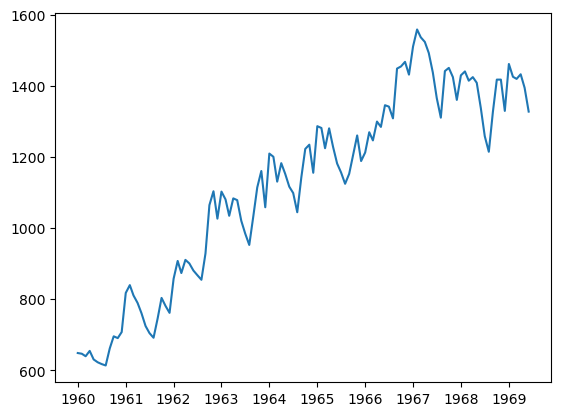

In [20]:
plt.plot(portland);

print('We can see that the seasonal effect increases over time, so we have a multiplicative model.')

# Seasonal decomposition :

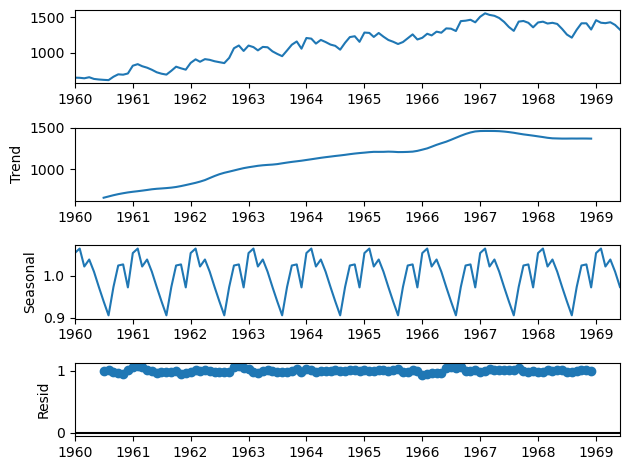

The previous graph pointed me in the direction of a multiplicative model. I did a decomposition without specifying the model argument to confirm my hypothesis. In fact, the decomposition was not successful in view of the last graph on the residuals. I then specified 'multiplicative' in the model argument as we are in a multiplicative model. In fact, the decomposition is better because the residuals no longer show variations as a function of time. We can identify an increasing trend that is linearly dependent on time and a 12-month seasonality here (we go from the middle of one year to the middle of the next.


In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

test = seasonal_decompose(portland, model = 'multiplicative')

test.plot()

plt.show()

print("The previous graph pointed me in the direction of a multiplicative model. I did a decomposition without specifying the model argument to confirm my hypothesis. In fact, the decomposition was not successful in view of the last graph on the residuals. I then specified 'multiplicative' in the model argument as we are in a multiplicative model. In fact, the decomposition is better because the residuals no longer show variations as a function of time. We can identify an increasing trend that is linearly dependent on time and a 12-month seasonality here (we go from the middle of one year to the middle of the next.")

# Autocorrelation :

We can see that the autocorrelation function decays relatively slowly. We will therefore apply a differentiation step in order to stationarise our dataset


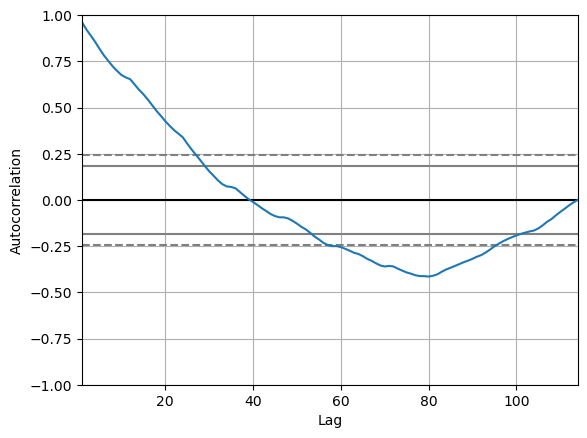

In [24]:
portland_log = np.log(portland)
pd.plotting.autocorrelation_plot(portland_log)

print('We can see that the autocorrelation function decays relatively slowly. We will therefore apply a differentiation step in order to stationarise our dataset')

# Differenciation :

Differentiation of order 1

0.26612552927665933

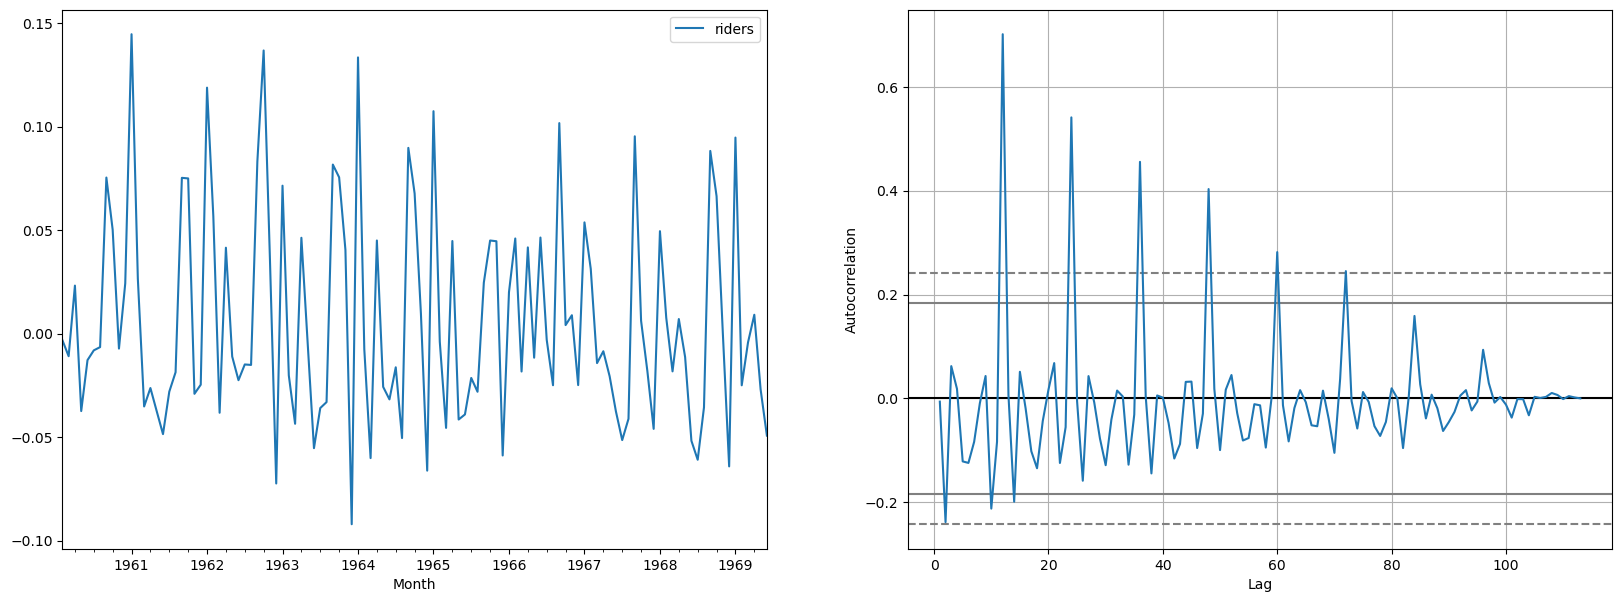

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

portland_log1 = portland_log.diff().dropna()
portland_log1.plot(ax = ax1)
pd.plotting.autocorrelation_plot(portland_log1, ax = ax2);

_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(portland_log1)
p_value


Differentiation by seasonality order 12 :

1.3094517085584272e-14

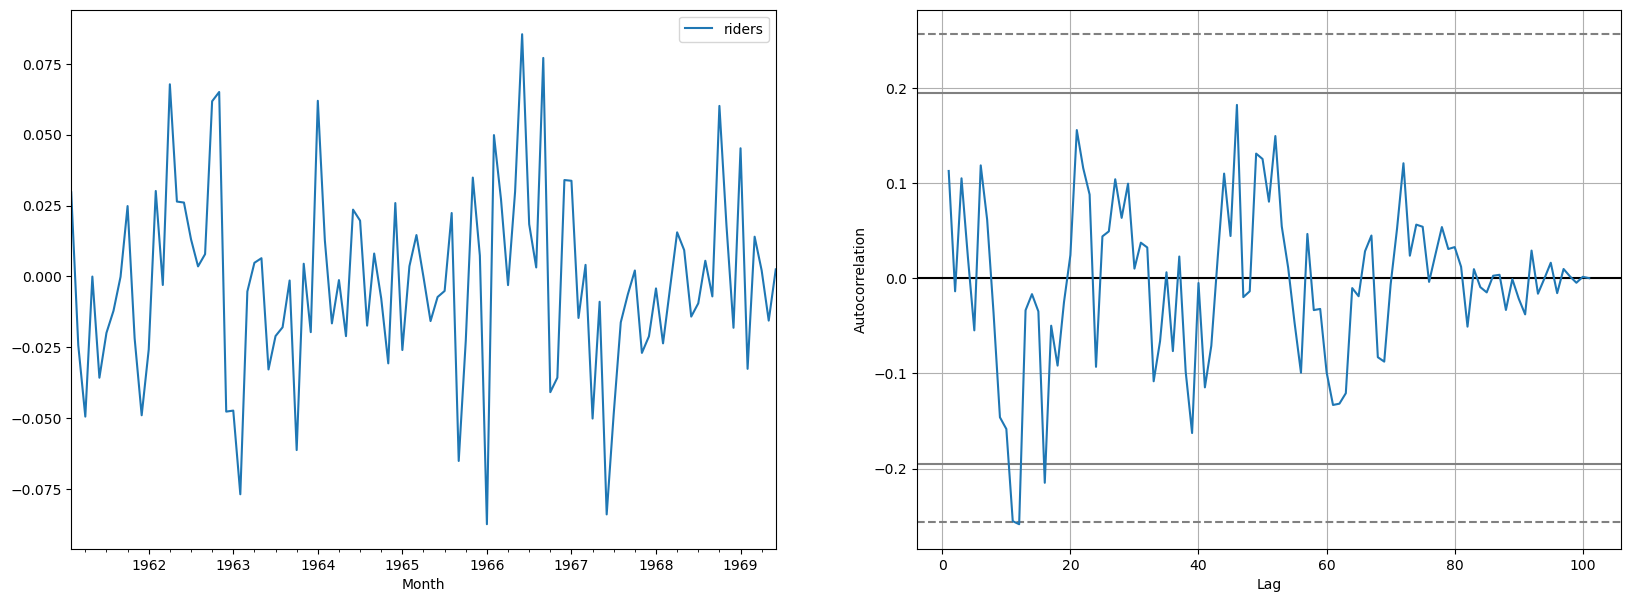

In [26]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,7))

portland_log2 = portland_log1.diff(periods = 12).dropna()
portland_log2.plot(ax = ax3)
pd.plotting.autocorrelation_plot(portland_log2, ax = ax4);

_, p_value, _, _, _, _  = sm.tsa.stattools.adfuller(portland_log2)
p_value

# Estimation of other parameters for a SARIMA model :

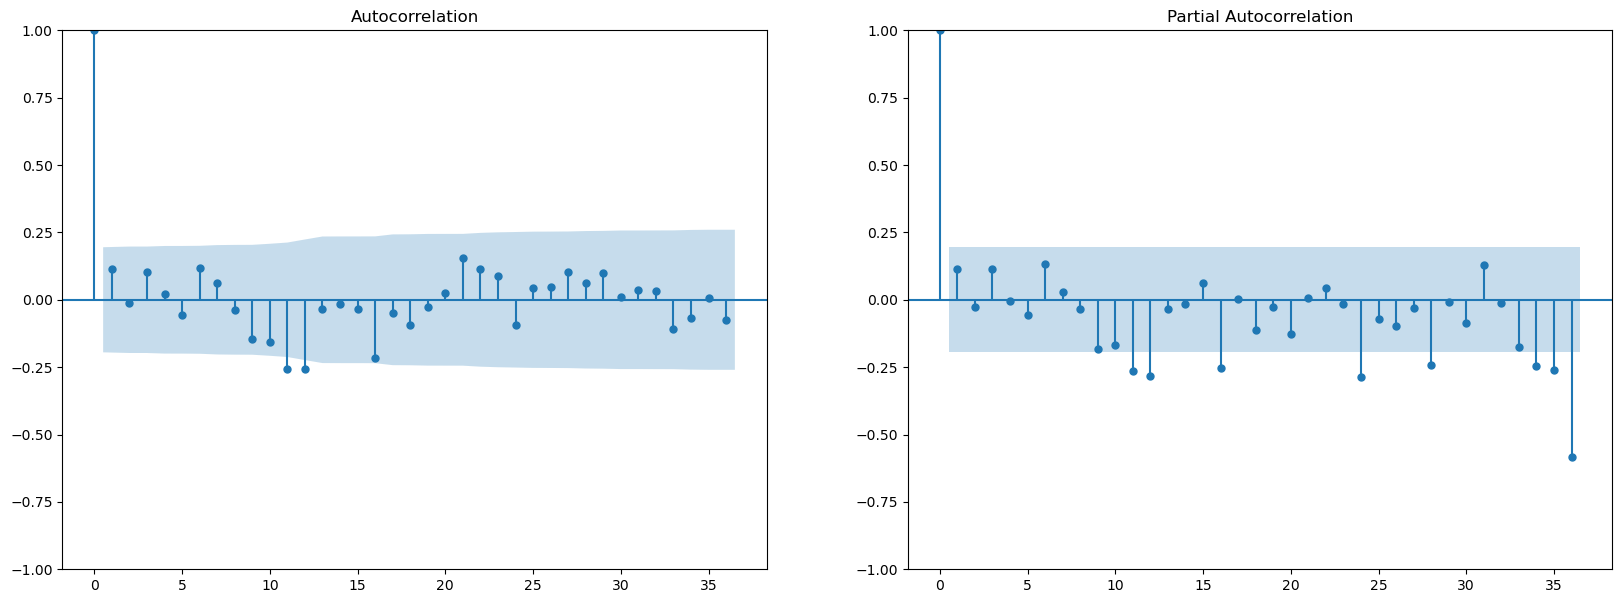

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(20,7))

plot_acf(portland_log2, lags = 36, ax=ax5)
plot_pacf(portland_log2, lags = 36, ax=ax6)
plt.show()

# SARIMAX model :

In [53]:
model=sm.tsa.SARIMAX(portland,order=(0,1,0),seasonal_order=(1,1,0,12))
sarima=model.fit()
print(sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             riders   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -508.669
Date:                            Thu, 01 Jun 2023   AIC                           1021.337
Time:                                    13:01:28   BIC                           1026.567
Sample:                                01-01-1960   HQIC                          1023.454
                                     - 06-01-1969                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2656      0.090     -2.949      0.003      -0.442      -0.089
sigma2      1374.7820    166.927   

C:\Users\beaux\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\beaux\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


# Predictions : 

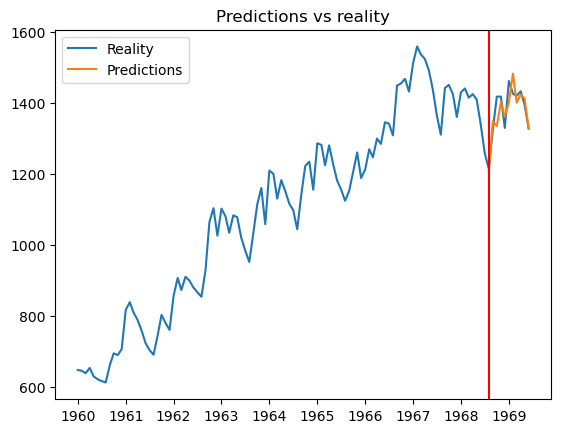

In [54]:
import datetime

pred = sarima.predict(103, 113)

plt.plot(portland, label = 'Reality')
plt.plot(pred, label = 'Predictions')

plt.title('Predictions vs reality')

plt.legend()

plt.axvline(x= datetime.date(1968,8,1), color='red');

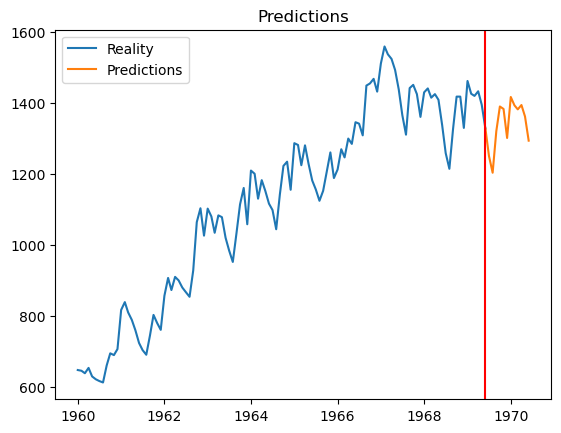

In [56]:
pred = sarima.predict(113, 125)

plt.plot(portland, label = 'Reality')
plt.plot(pred, label = 'Predictions')

plt.title('Predictions')

plt.legend()

plt.axvline(x= datetime.date(1969,6,1), color='red');